In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.measure import regionprops_table
from skimage.feature import greycomatrix, greycoprops
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

In [2]:
# Define the dataset directory
dataset_directory = "/content/drive/MyDrive/final year project/Train"

In [4]:
# Define GLCM parameters
glcm_distance = 1
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Initialize empty lists for storing features and labels
features = []
labels = []

# Loop through each class folder in the dataset directory
for class_folder in os.listdir(dataset_directory):
    class_folder_path = os.path.join(dataset_directory, class_folder)

    # Loop through each image file in the class folder
    for image_file in os.listdir(class_folder_path):
        image_path = os.path.join(class_folder_path, image_file)

        # Read and convert image to grayscale
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Rescale the image to 256x256
        gray_image = cv2.resize(gray_image, (256, 256))

        # Extract GLCM features
        glcm = greycomatrix(gray_image, distances=[glcm_distance], angles=glcm_angles, levels=256, symmetric=True, normed=True)
        glcm_features = greycoprops(glcm, prop='contrast').ravel().tolist()

        # Extract region properties
        label_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        props = regionprops_table(label_image, gray_image,
                                  properties=['convex_area', 'area', 'eccentricity',
                                              'extent', 'inertia_tensor',
                                              'major_axis_length', 'minor_axis_length',
                                              'perimeter', 'solidity',
                                              'orientation', 'moments_central',
                                              'moments_hu', 'euler_number',
                                              'equivalent_diameter',
                                              'mean_intensity', 'bbox'])

        # Calculate additional features
        props['perimeter_area_ratio'] = props['perimeter'] / props['area']

        color_features = cv2.mean(image)[:3]  # Extract mean BGR color values

        # Combine GLCM, region properties, and color features
        combined_features = glcm_features + list(props.values()) + list(color_features)

        # Append features and label to the lists
        features.append(combined_features)
        labels.append(class_folder)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version=

In [5]:
# Convert features and labels to pandas DataFrame
df = pd.DataFrame(features)

# Add the label column
df['label'] = labels

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']


In [6]:
# Perform feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC()

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

In [9]:
# Generate the classification report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report)

Classification Report:
               precision    recall  f1-score   support

   Abuldodam       0.74      0.91      0.82        70
       Aruda       0.97      0.89      0.93        75
      Athadi       0.89      0.97      0.93        61
     Dambala       0.96      1.00      0.98        65
  Dathkatiya       0.78      0.64      0.70        55
   Kabaranka       0.67      0.76      0.71        49
      Kapuru       0.86      0.93      0.90        69
  Karapincha       0.88      0.64      0.74        66
      Penala       0.98      0.94      0.96        54
 Pethi Thora       0.89      0.80      0.84        49
   Siyambala       0.83      0.84      0.83        57
  Strowberry       1.00      0.80      0.89         5
    Thakkali       0.80      0.91      0.85        54
       Tulsi       0.98      0.97      0.98        63

    accuracy                           0.86       792
   macro avg       0.87      0.86      0.86       792
weighted avg       0.87      0.86      0.86       792



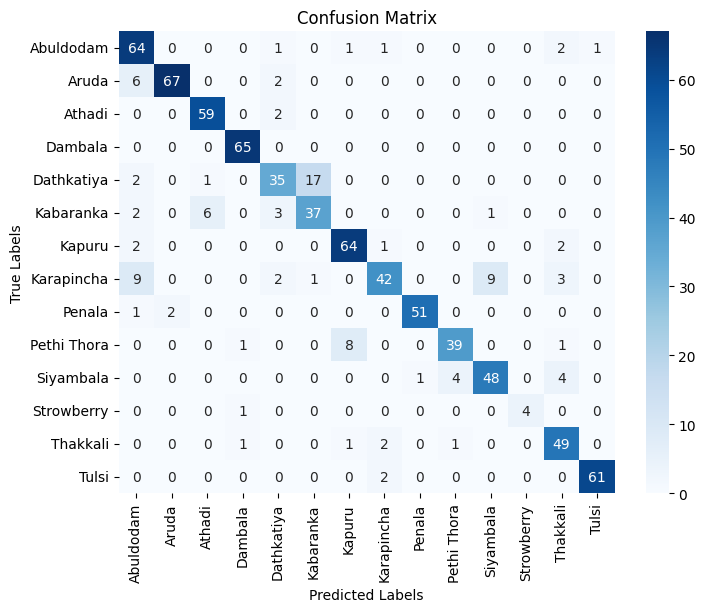

In [10]:
# Generate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Create a list of class labels
class_labels = sorted(set(y_test))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

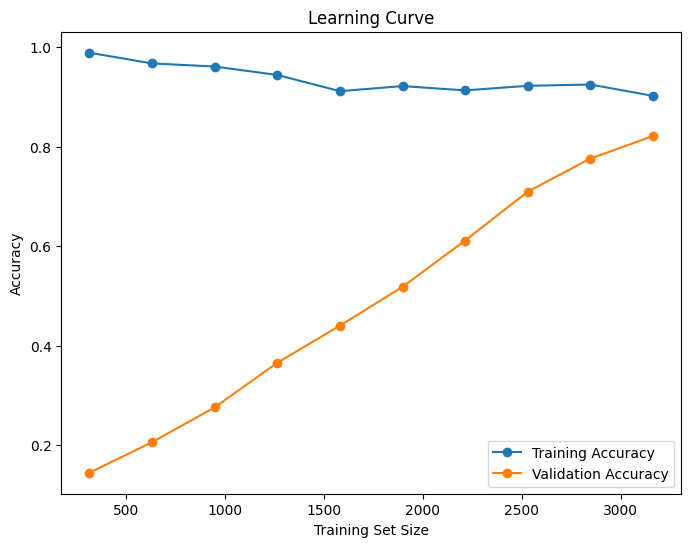

In [11]:
# Plot the learning curve
train_sizes, train_scores, val_scores = learning_curve(svm, X_pca, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Accuracy')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [13]:
# Save the trained model
import joblib
joblib.dump(svm, '/content/drive/MyDrive/final year project/svm_model.h5')

['/content/drive/MyDrive/final year project/svm_model.h5']